In [86]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import scipy
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import os
import keras.models
from sklearn.metrics import r2_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:

train_data = pd.read_csv("data/train_music.csv", sep=',')
# print(train_data.info())
# print(train_data.sample(5))
# print(train_data.describe())
# print(pd.isnull(train_data))



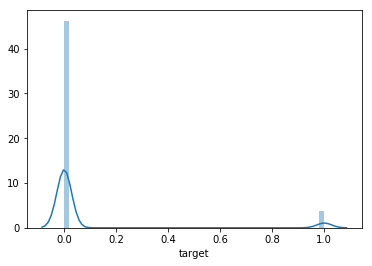

In [88]:
# undersample 0 class
sns.distplot(train_data['target'])

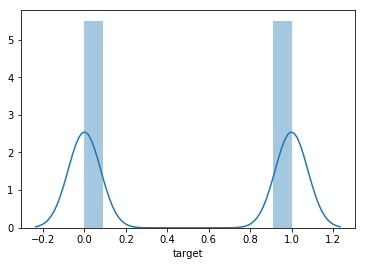

In [89]:
target_one_count = len(train_data[train_data['target'] == 1])
target_zero_indices = train_data[train_data.target == 0].index
target_zero_random_indices = np.random.choice(target_zero_indices, target_one_count, replace=False)
target_one_indices = train_data[train_data.target == 1].index
under_sample_indices = np.concatenate([target_one_indices, target_zero_random_indices])
train_data = train_data.loc[under_sample_indices]

sns.distplot(train_data['target'])

In [90]:
# split_to_train_test_sets
x = train_data.iloc[:, 2:train_data.shape[1]]
y = np.ravel(train_data.target)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


In [91]:
# find first columns with the best correlation
corframe = pd.DataFrame(columns=["ColName", "Corr", "NullCount", "Mean"])
line_count = x_train.index.size

for column in x_train:
    nas = np.logical_or(np.isnan(x_train[column].values), np.isnan(y_train))
    cor = abs(scipy.stats.stats.pearsonr(x_train[column].values[~nas], y_train[~nas])[0])
    # not to use columns with many nulls, more than 10%
    null_count = np.isnan(x_train[column].values).sum()
    if (null_count / line_count > 0.1):
        continue
    mean = x_train.loc[:, column].mean()
    df = pd.DataFrame([[column, cor, null_count, mean]], columns=["ColName", "Corr", "NullCount", "Mean"])
    corframe = corframe.append(df, ignore_index=True)

corframe = corframe.sort_values(by="Corr", ascending=False)
print(corframe.iloc[0:5, :])

# fill nan with mean
df_mean = x_train.mean()
x_train.fillna(df_mean, inplace=True)
x_test.fillna(df_mean, inplace=True)

C:\projects\vodafone_music_classificator\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


                ColName      Corr NullCount       Mean
5                    lt  0.332489         0   0.741685
140    content_count_m1  0.243384       207  61.018852
368    content_count_m3  0.224516       659  57.961106
255    content_count_m2  0.209931       446  59.949391
21   count_sms_source_5  0.121202       711   0.576900


C:\projects\vodafone_music_classificator\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [92]:
def get_model(x_train, y_train):
    model_path = './vod_music_model.h5'
    print(os.path.abspath(model_path))
    if os.path.isfile(model_path):
        model = keras.models.load_model(model_path);
    else:
        model = Sequential()

        # Add an input layer
        model.add(Dense(x_train.shape[1], activation='relu', input_shape=(x_train.shape[1],)))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.output_shape
        model.summary()
        model.get_config()
        model.get_weights()

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=1, validation_split=0.5)
        model.save(model_path)
    return model

def train(x_train, y_train):
    model = get_model(x_train, y_train)
    return model


In [93]:
# the count of most important features we will use
n_features = 4
model = train(x_train[corframe.values[0:n_features, 0]], y_train)
y_pred = model.predict(x_test[corframe.values[0:n_features, 0]])
cor_test = scipy.stats.stats.pearsonr(y_test, np.transpose(y_pred.round())[0])[0]
print("test-pred correlation: " + str(cor_test))
score = model.evaluate(x_test[corframe.values[0:n_features, 0]], y_test, verbose=1)
print("score" + str(score))


C:\projects\vodafone_music_classificator\vod_music_model.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 69
Trainable params: 69
Non-trainable params: 0
_________________________________________________________________


Train on 3710 samples, validate on 3711 samples
Epoch 1/10


   1/3710 [..............................] - ETA: 31:50 - loss: 0.0775 - acc: 1.0000

  66/3710 [..............................] - ETA: 31s - loss: 1.6338 - acc: 0.4242  

 133/3710 [>.............................] - ETA: 16s - loss: 1.2510 - acc: 0.4812

 216/3710 [>.............................] - ETA: 10s - loss: 1.1336 - acc: 0.4630

 283/3710 [=>............................] - ETA: 8s - loss: 1.0309 - acc: 0.4594 

 352/3710 [=>............................] - ETA: 7s - loss: 0.9848 - acc: 0.4517

 434/3710 [==>...........................] - ETA: 6s - loss: 0.9549 - acc: 0.4516

 502/3710 [===>..........................] - ETA: 5s - loss: 0.9295 - acc: 0.4661

 586/3710 [===>..........................] - ETA: 5s - loss: 0.9062 - acc: 0.4642

 656/3710 [====>.........................] - ETA: 4s - loss: 0.9101 - acc: 0.4710

 738/3710 [====>.........................] - ETA: 4s - loss: 0.8862 - acc: 0.4770

 798/3710 [=====>........................] - ETA: 4s - loss: 0.8815 - acc: 0.4837

 857/3710 [=====>........................] - ETA: 3s - loss: 0.8781 - acc: 0.4831

 927/3710 [======>.......................] - ETA: 3s - loss: 0.8723 - acc: 0.4854

 988/3710 [======>.......................] - ETA: 3s - loss: 0.8616 - acc: 0.4909

1058/3710 [=======>......................] - ETA: 3s - loss: 0.8508 - acc: 0.4934

1114/3710 [========>.....................] - ETA: 3s - loss: 0.8428 - acc: 0.4982



1182/3710 [========>.....................] - ETA: 3s - loss: 0.8366 - acc: 0.5017

1252/3710 [=========>....................] - ETA: 3s - loss: 0.8267 - acc: 0.5072

1325/3710 [=========>....................] - ETA: 2s - loss: 0.8197 - acc: 0.5057

1409/3710 [==========>...................] - ETA: 2s - loss: 0.8134 - acc: 0.5089

1479/3710 [==========>...................] - ETA: 2s - loss: 0.8061 - acc: 0.5098

1545/3710 [===========>..................] - ETA: 2s - loss: 0.8018 - acc: 0.5146

1607/3710 [===========>..................] - ETA: 2s - loss: 0.7988 - acc: 0.5146

1681/3710 [============>.................] - ETA: 2s - loss: 0.7929 - acc: 0.5158

1755/3710 [=============>................] - ETA: 2s - loss: 0.7876 - acc: 0.5185

1829/3710 [=============>................] - ETA: 2s - loss: 0.7828 - acc: 0.5238

1916/3710 [==============>...............] - ETA: 1s - loss: 0.7765 - acc: 0.5282

1989/3710 [===============>..............] - ETA: 1s - loss: 0.7750 - acc: 0.5294



2075/3710 [===============>..............] - ETA: 1s - loss: 0.7722 - acc: 0.5253

2145/3710 [================>.............] - ETA: 1s - loss: 0.7691 - acc: 0.5259

2233/3710 [=================>............] - ETA: 1s - loss: 0.7654 - acc: 0.5311

2309/3710 [=================>............] - ETA: 1s - loss: 0.7625 - acc: 0.5327

2365/3710 [==================>...........] - ETA: 1s - loss: 0.7611 - acc: 0.5332

2450/3710 [==================>...........] - ETA: 1s - loss: 0.7596 - acc: 0.5376

2526/3710 [===================>..........] - ETA: 1s - loss: 0.7569 - acc: 0.5368

2616/3710 [====================>.........] - ETA: 1s - loss: 0.7552 - acc: 0.5352

2693/3710 [====================>.........] - ETA: 0s - loss: 0.7530 - acc: 0.5362

2783/3710 [=====================>........] - ETA: 0s - loss: 0.7490 - acc: 0.5390

2856/3710 [======================>.......] - ETA: 0s - loss: 0.7474 - acc: 0.5392

2930/3710 [======================>.......] - ETA: 0s - loss: 0.7462 - acc: 0.5396

3021/3710 [=======================>......] - ETA: 0s - loss: 0.7436 - acc: 0.5396

3090/3710 [=======================>......] - ETA: 0s - loss: 0.7427 - acc: 0.5392

3174/3710 [========================>.....] - ETA: 0s - loss: 0.7399 - acc: 0.5419

3247/3710 [=========================>....] - ETA: 0s - loss: 0.7386 - acc: 0.5427

3335/3710 [=========================>....] - ETA: 0s - loss: 0.7366 - acc: 0.5427

3411/3710 [==========================>...] - ETA: 0s - loss: 0.7359 - acc: 0.5429

3486/3710 [===========================>..] - ETA: 0s - loss: 0.7341 - acc: 0.5442

3577/3710 [===========================>..] - ETA: 0s - loss: 0.7323 - acc: 0.5460

3649/3710 [============================>.] - ETA: 0s - loss: 0.7304 - acc: 0.5473

3710/3710 [==============================] - 5s 1ms/step - loss: 0.7299 - acc: 0.5480 - val_loss: 0.6705 - val_acc: 0.5901


Epoch 2/10
   1/3710 [..............................] - ETA: 0s - loss: 0.3322 - acc: 1.0000

  54/3710 [..............................] - ETA: 4s - loss: 0.6310 - acc: 0.6111

 113/3710 [..............................] - ETA: 3s - loss: 0.6394 - acc: 0.6106

 193/3710 [>.............................] - ETA: 3s - loss: 0.6568 - acc: 0.6010

 246/3710 [>.............................] - ETA: 3s - loss: 0.6467 - acc: 0.6138

 321/3710 [=>............................] - ETA: 3s - loss: 0.6522 - acc: 0.6199

 384/3710 [==>...........................] - ETA: 3s - loss: 0.6534 - acc: 0.6120

 455/3710 [==>...........................] - ETA: 2s - loss: 0.6563 - acc: 0.6044

 541/3710 [===>..........................] - ETA: 2s - loss: 0.6668 - acc: 0.5841

 607/3710 [===>..........................] - ETA: 2s - loss: 0.6658 - acc: 0.5766

 692/3710 [====>.........................] - ETA: 2s - loss: 0.6672 - acc: 0.5737

 762/3710 [=====>........................] - ETA: 2s - loss: 0.6628 - acc: 0.5866

 847/3710 [=====>........................] - ETA: 2s - loss: 0.6667 - acc: 0.5880

 917/3710 [======>.......................] - ETA: 2s - loss: 0.6647 - acc: 0.5954

 983/3710 [======>.......................] - ETA: 2s - loss: 0.6655 - acc: 0.5951

1070/3710 [=======>......................] - ETA: 2s - loss: 0.6642 - acc: 0.5916

1144/3710 [========>.....................] - ETA: 2s - loss: 0.6630 - acc: 0.5935



1225/3710 [========>.....................] - ETA: 1s - loss: 0.6625 - acc: 0.5935

1296/3710 [=========>....................] - ETA: 1s - loss: 0.6614 - acc: 0.5910

1380/3710 [==========>...................] - ETA: 1s - loss: 0.6618 - acc: 0.5899

1453/3710 [==========>...................] - ETA: 1s - loss: 0.6623 - acc: 0.5871

1527/3710 [===========>..................] - ETA: 1s - loss: 0.6613 - acc: 0.5900

1612/3710 [============>.................] - ETA: 1s - loss: 0.6624 - acc: 0.5875

1681/3710 [============>.................] - ETA: 1s - loss: 0.6635 - acc: 0.5842

1762/3710 [=============>................] - ETA: 1s - loss: 0.6641 - acc: 0.5846

1830/3710 [=============>................] - ETA: 1s - loss: 0.6646 - acc: 0.5847

1910/3710 [==============>...............] - ETA: 1s - loss: 0.6649 - acc: 0.5843

1979/3710 [===============>..............] - ETA: 1s - loss: 0.6640 - acc: 0.5867

2049/3710 [===============>..............] - ETA: 1s - loss: 0.6642 - acc: 0.5857

2136/3710 [================>.............] - ETA: 1s - loss: 0.6659 - acc: 0.5843

2202/3710 [================>.............] - ETA: 1s - loss: 0.6653 - acc: 0.5849

2271/3710 [=================>............] - ETA: 1s - loss: 0.6663 - acc: 0.5834

2336/3710 [=================>............] - ETA: 1s - loss: 0.6659 - acc: 0.5839

2419/3710 [==================>...........] - ETA: 1s - loss: 0.6667 - acc: 0.5854

2484/3710 [===================>..........] - ETA: 0s - loss: 0.6669 - acc: 0.5849

2568/3710 [===================>..........] - ETA: 0s - loss: 0.6679 - acc: 0.5829

2639/3710 [====================>.........] - ETA: 0s - loss: 0.6682 - acc: 0.5836

2707/3710 [====================>.........] - ETA: 0s - loss: 0.6685 - acc: 0.5840

2791/3710 [=====================>........] - ETA: 0s - loss: 0.6690 - acc: 0.5837

2860/3710 [======================>.......] - ETA: 0s - loss: 0.6698 - acc: 0.5815

2944/3710 [======================>.......] - ETA: 0s - loss: 0.6705 - acc: 0.5805

3013/3710 [=======================>......] - ETA: 0s - loss: 0.6703 - acc: 0.5805

3095/3710 [========================>.....] - ETA: 0s - loss: 0.6706 - acc: 0.5809

3164/3710 [========================>.....] - ETA: 0s - loss: 0.6709 - acc: 0.5809

3235/3710 [=========================>....] - ETA: 0s - loss: 0.6720 - acc: 0.5796

3320/3710 [=========================>....] - ETA: 0s - loss: 0.6726 - acc: 0.5783

3393/3710 [==========================>...] - ETA: 0s - loss: 0.6737 - acc: 0.5771

3457/3710 [==========================>...] - ETA: 0s - loss: 0.6734 - acc: 0.5774

3546/3710 [===========================>..] - ETA: 0s - loss: 0.6740 - acc: 0.5764

3623/3710 [============================>.] - ETA: 0s - loss: 0.6743 - acc: 0.5747

3694/3710 [============================>.] - ETA: 0s - loss: 0.6733 - acc: 0.5755

3710/3710 [==============================] - 4s 1ms/step - loss: 0.6734 - acc: 0.5747 - val_loss: 0.6755 - val_acc: 0.5823


Epoch 3/10
   1/3710 [..............................] - ETA: 0s - loss: 0.7248 - acc: 0.0000e+00

  66/3710 [..............................] - ETA: 3s - loss: 0.7005 - acc: 0.4545    

 126/3710 [>.............................] - ETA: 3s - loss: 0.7127 - acc: 0.4365

 206/3710 [>.............................] - ETA: 3s - loss: 0.6922 - acc: 0.4757

 264/3710 [=>............................] - ETA: 3s - loss: 0.6741 - acc: 0.5076

 330/3710 [=>............................] - ETA: 2s - loss: 0.6730 - acc: 0.5333

 397/3710 [==>...........................] - ETA: 2s - loss: 0.6676 - acc: 0.5466

 463/3710 [==>...........................] - ETA: 2s - loss: 0.6687 - acc: 0.5464

 545/3710 [===>..........................] - ETA: 2s - loss: 0.6714 - acc: 0.5523

 614/3710 [===>..........................] - ETA: 2s - loss: 0.6719 - acc: 0.5635

 697/3710 [====>.........................] - ETA: 2s - loss: 0.6730 - acc: 0.5638

 765/3710 [=====>........................] - ETA: 2s - loss: 0.6732 - acc: 0.5621

 826/3710 [=====>........................] - ETA: 2s - loss: 0.6696 - acc: 0.5642

 903/3710 [======>.......................] - ETA: 2s - loss: 0.6681 - acc: 0.5692

 971/3710 [======>.......................] - ETA: 2s - loss: 0.6657 - acc: 0.5757



1053/3710 [=======>......................] - ETA: 2s - loss: 0.6643 - acc: 0.5745

1117/3710 [========>.....................] - ETA: 2s - loss: 0.6627 - acc: 0.5748

1199/3710 [========>.....................] - ETA: 2s - loss: 0.6641 - acc: 0.5771

1272/3710 [=========>....................] - ETA: 1s - loss: 0.6669 - acc: 0.5715

1344/3710 [=========>....................] - ETA: 1s - loss: 0.6675 - acc: 0.5729

1431/3710 [==========>...................] - ETA: 1s - loss: 0.6694 - acc: 0.5737

1504/3710 [===========>..................] - ETA: 1s - loss: 0.6718 - acc: 0.5678

1590/3710 [===========>..................] - ETA: 1s - loss: 0.6701 - acc: 0.5704

1661/3710 [============>.................] - ETA: 1s - loss: 0.6709 - acc: 0.5707



1748/3710 [=============>................] - ETA: 1s - loss: 0.6712 - acc: 0.5709

1817/3710 [=============>................] - ETA: 1s - loss: 0.6710 - acc: 0.5707

1889/3710 [==============>...............] - ETA: 1s - loss: 0.6720 - acc: 0.5691

1977/3710 [==============>...............] - ETA: 1s - loss: 0.6732 - acc: 0.5670

2048/3710 [===============>..............] - ETA: 1s - loss: 0.6732 - acc: 0.5664

2134/3710 [================>.............] - ETA: 1s - loss: 0.6724 - acc: 0.5670

2192/3710 [================>.............] - ETA: 1s - loss: 0.6729 - acc: 0.5657

2276/3710 [=================>............] - ETA: 1s - loss: 0.6739 - acc: 0.5677

2348/3710 [=================>............] - ETA: 1s - loss: 0.6730 - acc: 0.5681

2420/3710 [==================>...........] - ETA: 1s - loss: 0.6742 - acc: 0.5657

2507/3710 [===================>..........] - ETA: 0s - loss: 0.6738 - acc: 0.5652

2578/3710 [===================>..........] - ETA: 0s - loss: 0.6748 - acc: 0.5663

2664/3710 [====================>.........] - ETA: 0s - loss: 0.6740 - acc: 0.5691

2738/3710 [=====================>........] - ETA: 0s - loss: 0.6745 - acc: 0.5687

2824/3710 [=====================>........] - ETA: 0s - loss: 0.6737 - acc: 0.5691

2896/3710 [======================>.......] - ETA: 0s - loss: 0.6741 - acc: 0.5691

2970/3710 [=======================>......] - ETA: 0s - loss: 0.6744 - acc: 0.5694

3057/3710 [=======================>......] - ETA: 0s - loss: 0.6731 - acc: 0.5721

3130/3710 [========================>.....] - ETA: 0s - loss: 0.6721 - acc: 0.5732

3197/3710 [========================>.....] - ETA: 0s - loss: 0.6722 - acc: 0.5721

3283/3710 [=========================>....] - ETA: 0s - loss: 0.6742 - acc: 0.5702

3356/3710 [==========================>...] - ETA: 0s - loss: 0.6734 - acc: 0.5730



3427/3710 [==========================>...] - ETA: 0s - loss: 0.6739 - acc: 0.5728

3496/3710 [===========================>..] - ETA: 0s - loss: 0.6738 - acc: 0.5727

3574/3710 [===========================>..] - ETA: 0s - loss: 0.6739 - acc: 0.5733

3649/3710 [============================>.] - ETA: 0s - loss: 0.6745 - acc: 0.5730

3710/3710 [==============================] - 4s 1ms/step - loss: 0.6747 - acc: 0.5722 - val_loss: 0.6807 - val_acc: 0.5715


Epoch 4/10
   1/3710 [..............................] - ETA: 0s - loss: 0.8498 - acc: 0.0000e+00

  65/3710 [..............................] - ETA: 3s - loss: 0.7216 - acc: 0.4769    

 129/3710 [>.............................] - ETA: 3s - loss: 0.6951 - acc: 0.5039

 210/3710 [>.............................] - ETA: 2s - loss: 0.6929 - acc: 0.5095

 277/3710 [=>............................] - ETA: 2s - loss: 0.6703 - acc: 0.5523

 347/3710 [=>............................] - ETA: 2s - loss: 0.6658 - acc: 0.5879

 429/3710 [==>...........................] - ETA: 2s - loss: 0.6641 - acc: 0.5921

 500/3710 [===>..........................] - ETA: 2s - loss: 0.6671 - acc: 0.5820

 581/3710 [===>..........................] - ETA: 2s - loss: 0.6708 - acc: 0.5886

 650/3710 [====>.........................] - ETA: 2s - loss: 0.6712 - acc: 0.5877

 732/3710 [====>.........................] - ETA: 2s - loss: 0.6730 - acc: 0.5847

 801/3710 [=====>........................] - ETA: 2s - loss: 0.6690 - acc: 0.5968

 872/3710 [======>.......................] - ETA: 2s - loss: 0.6676 - acc: 0.6089

 956/3710 [======>.......................] - ETA: 2s - loss: 0.6658 - acc: 0.6161

1029/3710 [=======>......................] - ETA: 2s - loss: 0.6649 - acc: 0.6171

1113/3710 [========>.....................] - ETA: 2s - loss: 0.6637 - acc: 0.6164

1186/3710 [========>.....................] - ETA: 1s - loss: 0.6685 - acc: 0.6071

1270/3710 [=========>....................] - ETA: 1s - loss: 0.6664 - acc: 0.6055

1343/3710 [=========>....................] - ETA: 1s - loss: 0.6699 - acc: 0.5987

1415/3710 [==========>...................] - ETA: 1s - loss: 0.6696 - acc: 0.5972

1500/3710 [===========>..................] - ETA: 1s - loss: 0.6689 - acc: 0.6020

1564/3710 [===========>..................] - ETA: 1s - loss: 0.6684 - acc: 0.6010

1629/3710 [============>.................] - ETA: 1s - loss: 0.6673 - acc: 0.6071

1716/3710 [============>.................] - ETA: 1s - loss: 0.6649 - acc: 0.6113

1800/3710 [=============>................] - ETA: 1s - loss: 0.6667 - acc: 0.6100

1873/3710 [==============>...............] - ETA: 1s - loss: 0.6658 - acc: 0.6103

1945/3710 [==============>...............] - ETA: 1s - loss: 0.6673 - acc: 0.6103

2030/3710 [===============>..............] - ETA: 1s - loss: 0.6663 - acc: 0.6118

2103/3710 [================>.............] - ETA: 1s - loss: 0.6670 - acc: 0.6096

2185/3710 [================>.............] - ETA: 1s - loss: 0.6663 - acc: 0.6082

2256/3710 [=================>............] - ETA: 1s - loss: 0.6675 - acc: 0.6077



2342/3710 [=================>............] - ETA: 1s - loss: 0.6667 - acc: 0.6055

2410/3710 [==================>...........] - ETA: 0s - loss: 0.6681 - acc: 0.6037

2479/3710 [===================>..........] - ETA: 0s - loss: 0.6681 - acc: 0.6035

2564/3710 [===================>..........] - ETA: 0s - loss: 0.6681 - acc: 0.6049

2622/3710 [====================>.........] - ETA: 0s - loss: 0.6679 - acc: 0.6056

2704/3710 [====================>.........] - ETA: 0s - loss: 0.6683 - acc: 0.6036

2777/3710 [=====================>........] - ETA: 0s - loss: 0.6695 - acc: 0.5999

2860/3710 [======================>.......] - ETA: 0s - loss: 0.6694 - acc: 0.5993

2933/3710 [======================>.......] - ETA: 0s - loss: 0.6700 - acc: 0.5970

2996/3710 [=======================>......] - ETA: 0s - loss: 0.6708 - acc: 0.5961

3084/3710 [=======================>......] - ETA: 0s - loss: 0.6710 - acc: 0.5957

3157/3710 [========================>.....] - ETA: 0s - loss: 0.6719 - acc: 0.5923

3240/3710 [=========================>....] - ETA: 0s - loss: 0.6720 - acc: 0.5904

3310/3710 [=========================>....] - ETA: 0s - loss: 0.6712 - acc: 0.5921

3396/3710 [==========================>...] - ETA: 0s - loss: 0.6714 - acc: 0.5913

3470/3710 [===========================>..] - ETA: 0s - loss: 0.6707 - acc: 0.5902

3543/3710 [===========================>..] - ETA: 0s - loss: 0.6700 - acc: 0.5907

3629/3710 [============================>.] - ETA: 0s - loss: 0.6704 - acc: 0.5880

3703/3710 [============================>.] - ETA: 0s - loss: 0.6707 - acc: 0.5879

3710/3710 [==============================] - 4s 1ms/step - loss: 0.6707 - acc: 0.5876 - val_loss: 0.6889 - val_acc: 0.5427


Epoch 5/10
   1/3710 [..............................] - ETA: 0s - loss: 0.5164 - acc: 1.0000

  53/3710 [..............................] - ETA: 3s - loss: 0.7296 - acc: 0.4906

  96/3710 [..............................] - ETA: 4s - loss: 0.6977 - acc: 0.5833

 155/3710 [>.............................] - ETA: 3s - loss: 0.6904 - acc: 0.5677

 208/3710 [>.............................] - ETA: 3s - loss: 0.6925 - acc: 0.5481

 272/3710 [=>............................] - ETA: 3s - loss: 0.6913 - acc: 0.5515

 331/3710 [=>............................] - ETA: 3s - loss: 0.6842 - acc: 0.5619



 389/3710 [==>...........................] - ETA: 3s - loss: 0.6743 - acc: 0.5810



 446/3710 [==>...........................] - ETA: 3s - loss: 0.6774 - acc: 0.5762

 496/3710 [===>..........................] - ETA: 3s - loss: 0.6764 - acc: 0.5786

 564/3710 [===>..........................] - ETA: 3s - loss: 0.6773 - acc: 0.5727

 626/3710 [====>.........................] - ETA: 3s - loss: 0.6745 - acc: 0.5751

 714/3710 [====>.........................] - ETA: 2s - loss: 0.6779 - acc: 0.5826

 786/3710 [=====>........................] - ETA: 2s - loss: 0.6760 - acc: 0.5827



 871/3710 [======>.......................] - ETA: 2s - loss: 0.6756 - acc: 0.5809

 941/3710 [======>.......................] - ETA: 2s - loss: 0.6786 - acc: 0.5824

1010/3710 [=======>......................] - ETA: 2s - loss: 0.6739 - acc: 0.5911

1097/3710 [=======>......................] - ETA: 2s - loss: 0.6748 - acc: 0.5852

1169/3710 [========>.....................] - ETA: 2s - loss: 0.6717 - acc: 0.5868



1256/3710 [=========>....................] - ETA: 2s - loss: 0.6716 - acc: 0.5892

1325/3710 [=========>....................] - ETA: 2s - loss: 0.6749 - acc: 0.5857

1414/3710 [==========>...................] - ETA: 1s - loss: 0.6723 - acc: 0.5884

1483/3710 [==========>...................] - ETA: 1s - loss: 0.6697 - acc: 0.5920

1557/3710 [===========>..................] - ETA: 1s - loss: 0.6692 - acc: 0.5934

1646/3710 [============>.................] - ETA: 1s - loss: 0.6693 - acc: 0.5923

1719/3710 [============>.................] - ETA: 1s - loss: 0.6707 - acc: 0.5910

1808/3710 [=============>................] - ETA: 1s - loss: 0.6709 - acc: 0.5902

1883/3710 [==============>...............] - ETA: 1s - loss: 0.6696 - acc: 0.5927



1973/3710 [==============>...............] - ETA: 1s - loss: 0.6698 - acc: 0.5910

2046/3710 [===============>..............] - ETA: 1s - loss: 0.6688 - acc: 0.5914

2118/3710 [================>.............] - ETA: 1s - loss: 0.6691 - acc: 0.5921

2206/3710 [================>.............] - ETA: 1s - loss: 0.6679 - acc: 0.5956

2281/3710 [=================>............] - ETA: 1s - loss: 0.6684 - acc: 0.5958

2370/3710 [==================>...........] - ETA: 1s - loss: 0.6690 - acc: 0.5928

2441/3710 [==================>...........] - ETA: 1s - loss: 0.6695 - acc: 0.5903



2522/3710 [===================>..........] - ETA: 0s - loss: 0.6685 - acc: 0.5916

2594/3710 [===================>..........] - ETA: 0s - loss: 0.6699 - acc: 0.5894

2667/3710 [====================>.........] - ETA: 0s - loss: 0.6699 - acc: 0.5894

2757/3710 [=====================>........] - ETA: 0s - loss: 0.6679 - acc: 0.5934

2833/3710 [=====================>........] - ETA: 0s - loss: 0.6689 - acc: 0.5912



2920/3710 [======================>.......] - ETA: 0s - loss: 0.6686 - acc: 0.5911

2993/3710 [=======================>......] - ETA: 0s - loss: 0.6699 - acc: 0.5904

3078/3710 [=======================>......] - ETA: 0s - loss: 0.6685 - acc: 0.5929

3152/3710 [========================>.....] - ETA: 0s - loss: 0.6690 - acc: 0.5926

3224/3710 [=========================>....] - ETA: 0s - loss: 0.6692 - acc: 0.5903

3305/3710 [=========================>....] - ETA: 0s - loss: 0.6696 - acc: 0.5894

3372/3710 [==========================>...] - ETA: 0s - loss: 0.6684 - acc: 0.5907

3462/3710 [==========================>...] - ETA: 0s - loss: 0.6687 - acc: 0.5924

3538/3710 [===========================>..] - ETA: 0s - loss: 0.6683 - acc: 0.5941



3626/3710 [============================>.] - ETA: 0s - loss: 0.6690 - acc: 0.5905

3696/3710 [============================>.] - ETA: 0s - loss: 0.6693 - acc: 0.5901

3710/3710 [==============================] - 4s 1ms/step - loss: 0.6694 - acc: 0.5900 - val_loss: 0.6648 - val_acc: 0.5920


Epoch 6/10
   1/3710 [..............................] - ETA: 0s - loss: 0.5380 - acc: 1.0000

  59/3710 [..............................] - ETA: 3s - loss: 0.6721 - acc: 0.6271

 126/3710 [>.............................] - ETA: 3s - loss: 0.6898 - acc: 0.5952

 193/3710 [>.............................] - ETA: 3s - loss: 0.6931 - acc: 0.5803

 268/3710 [=>............................] - ETA: 2s - loss: 0.6847 - acc: 0.5746

 337/3710 [=>............................] - ETA: 2s - loss: 0.6620 - acc: 0.6113

 420/3710 [==>...........................] - ETA: 2s - loss: 0.6542 - acc: 0.6167

 489/3710 [==>...........................] - ETA: 2s - loss: 0.6539 - acc: 0.6135

 570/3710 [===>..........................] - ETA: 2s - loss: 0.6616 - acc: 0.6000

 640/3710 [====>.........................] - ETA: 2s - loss: 0.6602 - acc: 0.6000

 710/3710 [====>.........................] - ETA: 2s - loss: 0.6596 - acc: 0.5972

 793/3710 [=====>........................] - ETA: 2s - loss: 0.6553 - acc: 0.6066

 863/3710 [=====>........................] - ETA: 2s - loss: 0.6574 - acc: 0.6037

 947/3710 [======>.......................] - ETA: 2s - loss: 0.6584 - acc: 0.6082

1014/3710 [=======>......................] - ETA: 2s - loss: 0.6605 - acc: 0.6085

1097/3710 [=======>......................] - ETA: 2s - loss: 0.6585 - acc: 0.6108

1166/3710 [========>.....................] - ETA: 2s - loss: 0.6585 - acc: 0.6098

1236/3710 [========>.....................] - ETA: 1s - loss: 0.6607 - acc: 0.6068

1315/3710 [=========>....................] - ETA: 1s - loss: 0.6591 - acc: 0.6091

1385/3710 [==========>...................] - ETA: 1s - loss: 0.6595 - acc: 0.6065



1467/3710 [==========>...................] - ETA: 1s - loss: 0.6584 - acc: 0.6080

1531/3710 [===========>..................] - ETA: 1s - loss: 0.6582 - acc: 0.6061

1612/3710 [============>.................] - ETA: 1s - loss: 0.6607 - acc: 0.6079

1682/3710 [============>.................] - ETA: 1s - loss: 0.6591 - acc: 0.6106

1752/3710 [=============>................] - ETA: 1s - loss: 0.6607 - acc: 0.6084

1835/3710 [=============>................] - ETA: 1s - loss: 0.6624 - acc: 0.6033

1905/3710 [==============>...............] - ETA: 1s - loss: 0.6632 - acc: 0.6031

1988/3710 [===============>..............] - ETA: 1s - loss: 0.6636 - acc: 0.6026

2058/3710 [===============>..............] - ETA: 1s - loss: 0.6618 - acc: 0.6054



2140/3710 [================>.............] - ETA: 1s - loss: 0.6632 - acc: 0.6042

2205/3710 [================>.............] - ETA: 1s - loss: 0.6628 - acc: 0.6032

2274/3710 [=================>............] - ETA: 1s - loss: 0.6634 - acc: 0.6016

2354/3710 [==================>...........] - ETA: 1s - loss: 0.6634 - acc: 0.6007

2425/3710 [==================>...........] - ETA: 1s - loss: 0.6639 - acc: 0.6000

2508/3710 [===================>..........] - ETA: 0s - loss: 0.6652 - acc: 0.5961

2575/3710 [===================>..........] - ETA: 0s - loss: 0.6652 - acc: 0.5953

2656/3710 [====================>.........] - ETA: 0s - loss: 0.6654 - acc: 0.5949

2725/3710 [=====================>........] - ETA: 0s - loss: 0.6643 - acc: 0.5963

2795/3710 [=====================>........] - ETA: 0s - loss: 0.6640 - acc: 0.5975

2877/3710 [======================>.......] - ETA: 0s - loss: 0.6624 - acc: 0.5999

2947/3710 [======================>.......] - ETA: 0s - loss: 0.6639 - acc: 0.5996

3028/3710 [=======================>......] - ETA: 0s - loss: 0.6647 - acc: 0.5991

3099/3710 [========================>.....] - ETA: 0s - loss: 0.6648 - acc: 0.5989

3181/3710 [========================>.....] - ETA: 0s - loss: 0.6649 - acc: 0.5982

3250/3710 [=========================>....] - ETA: 0s - loss: 0.6656 - acc: 0.5966

3320/3710 [=========================>....] - ETA: 0s - loss: 0.6654 - acc: 0.5967

3401/3710 [==========================>...] - ETA: 0s - loss: 0.6660 - acc: 0.5957

3470/3710 [===========================>..] - ETA: 0s - loss: 0.6664 - acc: 0.5948

3535/3710 [===========================>..] - ETA: 0s - loss: 0.6663 - acc: 0.5943

3609/3710 [============================>.] - ETA: 0s - loss: 0.6653 - acc: 0.5949



3692/3710 [============================>.] - ETA: 0s - loss: 0.6660 - acc: 0.5934

3710/3710 [==============================] - 4s 1ms/step - loss: 0.6661 - acc: 0.5930 - val_loss: 0.6654 - val_acc: 0.5934


Epoch 7/10
   1/3710 [..............................] - ETA: 0s - loss: 0.6237 - acc: 1.0000

  70/3710 [..............................] - ETA: 3s - loss: 0.6695 - acc: 0.6000

 131/3710 [>.............................] - ETA: 3s - loss: 0.6807 - acc: 0.5573

 210/3710 [>.............................] - ETA: 2s - loss: 0.6665 - acc: 0.5905

 277/3710 [=>............................] - ETA: 2s - loss: 0.6679 - acc: 0.5921

 346/3710 [=>............................] - ETA: 2s - loss: 0.6712 - acc: 0.5867

 427/3710 [==>...........................] - ETA: 2s - loss: 0.6640 - acc: 0.5972

 496/3710 [===>..........................] - ETA: 2s - loss: 0.6714 - acc: 0.5786

 575/3710 [===>..........................] - ETA: 2s - loss: 0.6726 - acc: 0.5704

 643/3710 [====>.........................] - ETA: 2s - loss: 0.6688 - acc: 0.5754

 722/3710 [====>.........................] - ETA: 2s - loss: 0.6674 - acc: 0.5762

 791/3710 [=====>........................] - ETA: 2s - loss: 0.6656 - acc: 0.5828

 860/3710 [=====>........................] - ETA: 2s - loss: 0.6685 - acc: 0.5860

 936/3710 [======>.......................] - ETA: 2s - loss: 0.6715 - acc: 0.5833

1004/3710 [=======>......................] - ETA: 2s - loss: 0.6730 - acc: 0.5817

1083/3710 [=======>......................] - ETA: 2s - loss: 0.6740 - acc: 0.5743

1149/3710 [========>.....................] - ETA: 2s - loss: 0.6747 - acc: 0.5770

1228/3710 [========>.....................] - ETA: 1s - loss: 0.6736 - acc: 0.5806

1298/3710 [=========>....................] - ETA: 1s - loss: 0.6722 - acc: 0.5809

1366/3710 [==========>...................] - ETA: 1s - loss: 0.6720 - acc: 0.5798

1448/3710 [==========>...................] - ETA: 1s - loss: 0.6703 - acc: 0.5836

1516/3710 [===========>..................] - ETA: 1s - loss: 0.6700 - acc: 0.5844

1596/3710 [===========>..................] - ETA: 1s - loss: 0.6688 - acc: 0.5827

1663/3710 [============>.................] - ETA: 1s - loss: 0.6659 - acc: 0.5833

1724/3710 [============>.................] - ETA: 1s - loss: 0.6670 - acc: 0.5847

1776/3710 [=============>................] - ETA: 1s - loss: 0.6666 - acc: 0.5850

1841/3710 [=============>................] - ETA: 1s - loss: 0.6661 - acc: 0.5850

1921/3710 [==============>...............] - ETA: 1s - loss: 0.6673 - acc: 0.5830

1988/3710 [===============>..............] - ETA: 1s - loss: 0.6671 - acc: 0.5830



2067/3710 [===============>..............] - ETA: 1s - loss: 0.6672 - acc: 0.5820

2132/3710 [================>.............] - ETA: 1s - loss: 0.6672 - acc: 0.5863

2196/3710 [================>.............] - ETA: 1s - loss: 0.6674 - acc: 0.5847

2261/3710 [=================>............] - ETA: 1s - loss: 0.6674 - acc: 0.5851

2324/3710 [=================>............] - ETA: 1s - loss: 0.6661 - acc: 0.5882

2398/3710 [==================>...........] - ETA: 1s - loss: 0.6661 - acc: 0.5909

2470/3710 [==================>...........] - ETA: 1s - loss: 0.6655 - acc: 0.5923

2558/3710 [===================>..........] - ETA: 0s - loss: 0.6646 - acc: 0.5930

2633/3710 [====================>.........] - ETA: 0s - loss: 0.6641 - acc: 0.5936



2722/3710 [=====================>........] - ETA: 0s - loss: 0.6617 - acc: 0.5966

2794/3710 [=====================>........] - ETA: 0s - loss: 0.6614 - acc: 0.5970

2859/3710 [======================>.......] - ETA: 0s - loss: 0.6621 - acc: 0.5960

2943/3710 [======================>.......] - ETA: 0s - loss: 0.6634 - acc: 0.5950

3016/3710 [=======================>......] - ETA: 0s - loss: 0.6632 - acc: 0.5945

3104/3710 [========================>.....] - ETA: 0s - loss: 0.6635 - acc: 0.5944

3178/3710 [========================>.....] - ETA: 0s - loss: 0.6631 - acc: 0.5957

3264/3710 [=========================>....] - ETA: 0s - loss: 0.6641 - acc: 0.5959

3338/3710 [=========================>....] - ETA: 0s - loss: 0.6627 - acc: 0.5974

3412/3710 [==========================>...] - ETA: 0s - loss: 0.6628 - acc: 0.5979

3495/3710 [===========================>..] - ETA: 0s - loss: 0.6625 - acc: 0.5983

3569/3710 [===========================>..] - ETA: 0s - loss: 0.6637 - acc: 0.5962



3656/3710 [============================>.] - ETA: 0s - loss: 0.6634 - acc: 0.5957

3710/3710 [==============================] - 4s 1ms/step - loss: 0.6636 - acc: 0.5949 - val_loss: 0.6702 - val_acc: 0.5893


Epoch 8/10
   1/3710 [..............................] - ETA: 0s - loss: 0.6000 - acc: 1.0000

  58/3710 [..............................] - ETA: 3s - loss: 0.6102 - acc: 0.6379

 128/3710 [>.............................] - ETA: 3s - loss: 0.6277 - acc: 0.6406

 193/3710 [>.............................] - ETA: 3s - loss: 0.6352 - acc: 0.6528

 274/3710 [=>............................] - ETA: 2s - loss: 0.6307 - acc: 0.6679

 340/3710 [=>............................] - ETA: 2s - loss: 0.6350 - acc: 0.6559

 408/3710 [==>...........................] - ETA: 2s - loss: 0.6299 - acc: 0.6520

 490/3710 [==>...........................] - ETA: 2s - loss: 0.6277 - acc: 0.6551

 558/3710 [===>..........................] - ETA: 2s - loss: 0.6309 - acc: 0.6470

 636/3710 [====>.........................] - ETA: 2s - loss: 0.6385 - acc: 0.6462

 700/3710 [====>.........................] - ETA: 2s - loss: 0.6487 - acc: 0.6443

 778/3710 [=====>........................] - ETA: 2s - loss: 0.6519 - acc: 0.6298

 840/3710 [=====>........................] - ETA: 2s - loss: 0.6541 - acc: 0.6262

 899/3710 [======>.......................] - ETA: 2s - loss: 0.6480 - acc: 0.6307

 974/3710 [======>.......................] - ETA: 2s - loss: 0.6527 - acc: 0.6222

1044/3710 [=======>......................] - ETA: 2s - loss: 0.6535 - acc: 0.6178

1125/3710 [========>.....................] - ETA: 2s - loss: 0.6520 - acc: 0.6204

1192/3710 [========>.....................] - ETA: 2s - loss: 0.6506 - acc: 0.6225

1272/3710 [=========>....................] - ETA: 1s - loss: 0.6568 - acc: 0.6132

1341/3710 [=========>....................] - ETA: 1s - loss: 0.6531 - acc: 0.6204

1407/3710 [==========>...................] - ETA: 1s - loss: 0.6563 - acc: 0.6190

1479/3710 [==========>...................] - ETA: 1s - loss: 0.6558 - acc: 0.6193

1563/3710 [===========>..................] - ETA: 1s - loss: 0.6564 - acc: 0.6161

1644/3710 [============>.................] - ETA: 1s - loss: 0.6545 - acc: 0.6174

1713/3710 [============>.................] - ETA: 1s - loss: 0.6538 - acc: 0.6182

1794/3710 [=============>................] - ETA: 1s - loss: 0.6523 - acc: 0.6154

1862/3710 [==============>...............] - ETA: 1s - loss: 0.6555 - acc: 0.6133

1930/3710 [==============>...............] - ETA: 1s - loss: 0.6565 - acc: 0.6104

2014/3710 [===============>..............] - ETA: 1s - loss: 0.6588 - acc: 0.6072

2081/3710 [===============>..............] - ETA: 1s - loss: 0.6605 - acc: 0.6045

2162/3710 [================>.............] - ETA: 1s - loss: 0.6601 - acc: 0.6064

2231/3710 [=================>............] - ETA: 1s - loss: 0.6626 - acc: 0.6042

2312/3710 [=================>............] - ETA: 1s - loss: 0.6611 - acc: 0.6060

2381/3710 [==================>...........] - ETA: 1s - loss: 0.6607 - acc: 0.6056

2450/3710 [==================>...........] - ETA: 0s - loss: 0.6615 - acc: 0.6041

2515/3710 [===================>..........] - ETA: 0s - loss: 0.6611 - acc: 0.6040

2602/3710 [====================>.........] - ETA: 0s - loss: 0.6616 - acc: 0.6022

2683/3710 [====================>.........] - ETA: 0s - loss: 0.6635 - acc: 0.6012

2753/3710 [=====================>........] - ETA: 0s - loss: 0.6637 - acc: 0.6019

2828/3710 [=====================>........] - ETA: 0s - loss: 0.6643 - acc: 0.6011

2905/3710 [======================>.......] - ETA: 0s - loss: 0.6639 - acc: 0.6007

2973/3710 [=======================>......] - ETA: 0s - loss: 0.6635 - acc: 0.6031

3057/3710 [=======================>......] - ETA: 0s - loss: 0.6628 - acc: 0.6035

3126/3710 [========================>.....] - ETA: 0s - loss: 0.6629 - acc: 0.6052

3205/3710 [========================>.....] - ETA: 0s - loss: 0.6635 - acc: 0.6016

3275/3710 [=========================>....] - ETA: 0s - loss: 0.6644 - acc: 0.5997

3354/3710 [==========================>...] - ETA: 0s - loss: 0.6652 - acc: 0.5984

3423/3710 [==========================>...] - ETA: 0s - loss: 0.6649 - acc: 0.5995

3492/3710 [===========================>..] - ETA: 0s - loss: 0.6648 - acc: 0.5988

3575/3710 [===========================>..] - ETA: 0s - loss: 0.6646 - acc: 0.5983

3644/3710 [============================>.] - ETA: 0s - loss: 0.6648 - acc: 0.5982

3710/3710 [==============================] - 4s 1ms/step - loss: 0.6646 - acc: 0.5981 - val_loss: 0.6635 - val_acc: 0.5939


Epoch 9/10
   1/3710 [..............................] - ETA: 0s - loss: 0.3146 - acc: 1.0000

  47/3710 [..............................] - ETA: 4s - loss: 0.6866 - acc: 0.5745

 116/3710 [..............................] - ETA: 3s - loss: 0.7253 - acc: 0.4655

 183/3710 [>.............................] - ETA: 3s - loss: 0.6817 - acc: 0.5082

 262/3710 [=>............................] - ETA: 3s - loss: 0.6877 - acc: 0.5038

 330/3710 [=>............................] - ETA: 2s - loss: 0.6842 - acc: 0.5152

 412/3710 [==>...........................] - ETA: 2s - loss: 0.6883 - acc: 0.5267

 480/3710 [==>...........................] - ETA: 2s - loss: 0.6844 - acc: 0.5375

 550/3710 [===>..........................] - ETA: 2s - loss: 0.6872 - acc: 0.5436

 630/3710 [====>.........................] - ETA: 2s - loss: 0.6903 - acc: 0.5349

 699/3710 [====>.........................] - ETA: 2s - loss: 0.6867 - acc: 0.5436

 781/3710 [=====>........................] - ETA: 2s - loss: 0.6874 - acc: 0.5365

 850/3710 [=====>........................] - ETA: 2s - loss: 0.6842 - acc: 0.5400

 932/3710 [======>.......................] - ETA: 2s - loss: 0.6825 - acc: 0.5461

1000/3710 [=======>......................] - ETA: 2s - loss: 0.6799 - acc: 0.5520

1070/3710 [=======>......................] - ETA: 2s - loss: 0.6791 - acc: 0.5514

1147/3710 [========>.....................] - ETA: 2s - loss: 0.6751 - acc: 0.5588

1219/3710 [========>.....................] - ETA: 1s - loss: 0.6763 - acc: 0.5578

1300/3710 [=========>....................] - ETA: 1s - loss: 0.6738 - acc: 0.5623

1369/3710 [==========>...................] - ETA: 1s - loss: 0.6741 - acc: 0.5646

1449/3710 [==========>...................] - ETA: 1s - loss: 0.6703 - acc: 0.5700

1514/3710 [===========>..................] - ETA: 1s - loss: 0.6694 - acc: 0.5727

1583/3710 [===========>..................] - ETA: 1s - loss: 0.6677 - acc: 0.5786

1663/3710 [============>.................] - ETA: 1s - loss: 0.6674 - acc: 0.5803

1732/3710 [=============>................] - ETA: 1s - loss: 0.6658 - acc: 0.5855

1814/3710 [=============>................] - ETA: 1s - loss: 0.6657 - acc: 0.5854

1883/3710 [==============>...............] - ETA: 1s - loss: 0.6648 - acc: 0.5895

1964/3710 [==============>...............] - ETA: 1s - loss: 0.6641 - acc: 0.5901

2033/3710 [===============>..............] - ETA: 1s - loss: 0.6643 - acc: 0.5898

2102/3710 [===============>..............] - ETA: 1s - loss: 0.6647 - acc: 0.5890

2182/3710 [================>.............] - ETA: 1s - loss: 0.6635 - acc: 0.5917

2250/3710 [=================>............] - ETA: 1s - loss: 0.6629 - acc: 0.5898



2329/3710 [=================>............] - ETA: 1s - loss: 0.6642 - acc: 0.5891

2394/3710 [==================>...........] - ETA: 1s - loss: 0.6642 - acc: 0.5886

2474/3710 [===================>..........] - ETA: 0s - loss: 0.6640 - acc: 0.5897

2542/3710 [===================>..........] - ETA: 0s - loss: 0.6626 - acc: 0.5917

2607/3710 [====================>.........] - ETA: 0s - loss: 0.6620 - acc: 0.5938

2688/3710 [====================>.........] - ETA: 0s - loss: 0.6625 - acc: 0.5926

2759/3710 [=====================>........] - ETA: 0s - loss: 0.6624 - acc: 0.5922

2838/3710 [=====================>........] - ETA: 0s - loss: 0.6628 - acc: 0.5927

2907/3710 [======================>.......] - ETA: 0s - loss: 0.6629 - acc: 0.5913

2990/3710 [=======================>......] - ETA: 0s - loss: 0.6634 - acc: 0.5903

3058/3710 [=======================>......] - ETA: 0s - loss: 0.6630 - acc: 0.5912

3128/3710 [========================>.....] - ETA: 0s - loss: 0.6628 - acc: 0.5918

3209/3710 [========================>.....] - ETA: 0s - loss: 0.6622 - acc: 0.5924

3278/3710 [=========================>....] - ETA: 0s - loss: 0.6616 - acc: 0.5933

3360/3710 [==========================>...] - ETA: 0s - loss: 0.6632 - acc: 0.5905

3430/3710 [==========================>...] - ETA: 0s - loss: 0.6621 - acc: 0.5918

3510/3710 [===========================>..] - ETA: 0s - loss: 0.6605 - acc: 0.5940

3581/3710 [===========================>..] - ETA: 0s - loss: 0.6600 - acc: 0.5965

3651/3710 [============================>.] - ETA: 0s - loss: 0.6603 - acc: 0.5971

3710/3710 [==============================] - 4s 1ms/step - loss: 0.6602 - acc: 0.5968 - val_loss: 0.6618 - val_acc: 0.5918


Epoch 10/10
   1/3710 [..............................] - ETA: 57s - loss: 0.7466 - acc: 0.0000e+00

  70/3710 [..............................] - ETA: 4s - loss: 0.6931 - acc: 0.5429     

 131/3710 [>.............................] - ETA: 3s - loss: 0.6617 - acc: 0.5954

 198/3710 [>.............................] - ETA: 3s - loss: 0.6818 - acc: 0.5808

 279/3710 [=>............................] - ETA: 3s - loss: 0.6702 - acc: 0.5950

 349/3710 [=>............................] - ETA: 2s - loss: 0.6626 - acc: 0.6189

 429/3710 [==>...........................] - ETA: 2s - loss: 0.6574 - acc: 0.6177

 495/3710 [===>..........................] - ETA: 2s - loss: 0.6503 - acc: 0.6323



 578/3710 [===>..........................] - ETA: 2s - loss: 0.6491 - acc: 0.6384

 647/3710 [====>.........................] - ETA: 2s - loss: 0.6492 - acc: 0.6368

 714/3710 [====>.........................] - ETA: 2s - loss: 0.6500 - acc: 0.6387

 797/3710 [=====>........................] - ETA: 2s - loss: 0.6416 - acc: 0.6474

 868/3710 [======>.......................] - ETA: 2s - loss: 0.6420 - acc: 0.6452

 948/3710 [======>.......................] - ETA: 2s - loss: 0.6456 - acc: 0.6403

1006/3710 [=======>......................] - ETA: 2s - loss: 0.6473 - acc: 0.6342

1091/3710 [=======>......................] - ETA: 2s - loss: 0.6494 - acc: 0.6260

1161/3710 [========>.....................] - ETA: 2s - loss: 0.6464 - acc: 0.6305

1231/3710 [========>.....................] - ETA: 1s - loss: 0.6574 - acc: 0.6231

1318/3710 [=========>....................] - ETA: 1s - loss: 0.6611 - acc: 0.6161

1390/3710 [==========>...................] - ETA: 1s - loss: 0.6621 - acc: 0.6108



1475/3710 [==========>...................] - ETA: 1s - loss: 0.6593 - acc: 0.6142

1547/3710 [===========>..................] - ETA: 1s - loss: 0.6617 - acc: 0.6115

1630/3710 [============>.................] - ETA: 1s - loss: 0.6618 - acc: 0.6061

1702/3710 [============>.................] - ETA: 1s - loss: 0.6619 - acc: 0.6052

1775/3710 [=============>................] - ETA: 1s - loss: 0.6643 - acc: 0.6017

1859/3710 [==============>...............] - ETA: 1s - loss: 0.6628 - acc: 0.6057

1932/3710 [==============>...............] - ETA: 1s - loss: 0.6632 - acc: 0.6051

2018/3710 [===============>..............] - ETA: 1s - loss: 0.6638 - acc: 0.6056

2089/3710 [===============>..............] - ETA: 1s - loss: 0.6647 - acc: 0.6022

2173/3710 [================>.............] - ETA: 1s - loss: 0.6657 - acc: 0.6010

2250/3710 [=================>............] - ETA: 1s - loss: 0.6659 - acc: 0.6022

2315/3710 [=================>............] - ETA: 1s - loss: 0.6659 - acc: 0.6017

2398/3710 [==================>...........] - ETA: 1s - loss: 0.6667 - acc: 0.6030

2471/3710 [==================>...........] - ETA: 0s - loss: 0.6663 - acc: 0.6026

2552/3710 [===================>..........] - ETA: 0s - loss: 0.6660 - acc: 0.6034

2626/3710 [====================>.........] - ETA: 0s - loss: 0.6641 - acc: 0.6047

2709/3710 [====================>.........] - ETA: 0s - loss: 0.6637 - acc: 0.6080

2781/3710 [=====================>........] - ETA: 0s - loss: 0.6624 - acc: 0.6091

2853/3710 [======================>.......] - ETA: 0s - loss: 0.6619 - acc: 0.6092

2940/3710 [======================>.......] - ETA: 0s - loss: 0.6628 - acc: 0.6085

3011/3710 [=======================>......] - ETA: 0s - loss: 0.6632 - acc: 0.6068



3098/3710 [========================>.....] - ETA: 0s - loss: 0.6633 - acc: 0.6046

3167/3710 [========================>.....] - ETA: 0s - loss: 0.6627 - acc: 0.6050

3250/3710 [=========================>....] - ETA: 0s - loss: 0.6637 - acc: 0.6006

3322/3710 [=========================>....] - ETA: 0s - loss: 0.6636 - acc: 0.6005

3394/3710 [==========================>...] - ETA: 0s - loss: 0.6641 - acc: 0.5987

3480/3710 [===========================>..] - ETA: 0s - loss: 0.6640 - acc: 0.5989

3552/3710 [===========================>..] - ETA: 0s - loss: 0.6639 - acc: 0.5997

3638/3710 [============================>.] - ETA: 0s - loss: 0.6637 - acc: 0.5970

3710/3710 [==============================] - 4s 1ms/step - loss: 0.6630 - acc: 0.5987 - val_loss: 0.6628 - val_acc: 0.5931


test-pred correlation: 0.19288508890929879
  32/3181 [..............................] - ETA: 0s

2720/3181 [========================>.....] - ETA: 0s

3181/3181 [==============================] - 0s 17us/step


score[0.6661475581854479, 0.5922665828730617]


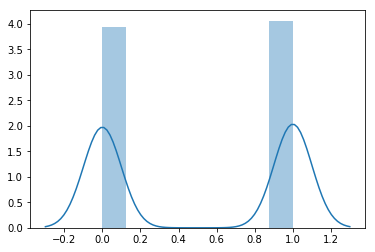

In [94]:
sns.distplot(np.transpose(y_test))


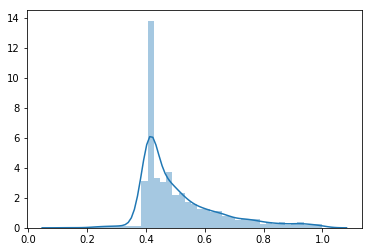

In [95]:
sns.distplot(np.transpose(y_pred)[0])


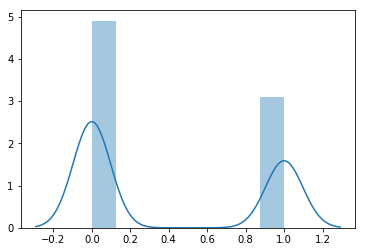

In [96]:
sns.distplot(np.transpose(y_pred.round())[0])
